# Imports

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from skimage import measure
import imageio
import  cv2
%matplotlib inline

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model,load_model
from tensorflow.keras.layers import Dense, Flatten, Conv1D, Conv2D, Input, Conv2DTranspose, Concatenate, MaxPool1D, Dropout, Reshape, Lambda, InputLayer, LeakyReLU, BatchNormalization, GaussianNoise
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras.losses import MeanSquaredError, kullback_leibler_divergence
from tensorflow.keras.metrics import BinaryCrossentropy
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.constraints import Constraint
import warnings
import logging
warnings.simplefilter("ignore")
logging.getLogger("tensorflow").setLevel(logging.ERROR)

tf.autograph.set_verbosity(0)
os.environ['AUTOGRAPH_VERBOSITY'] = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '0'

## Test GPU

In [2]:
physical_devices = tf.config.list_physical_devices('GPU') 
print("GPUs available:",len(physical_devices))

GPUs available: 1


# Data preparation

Good = 17.70 %


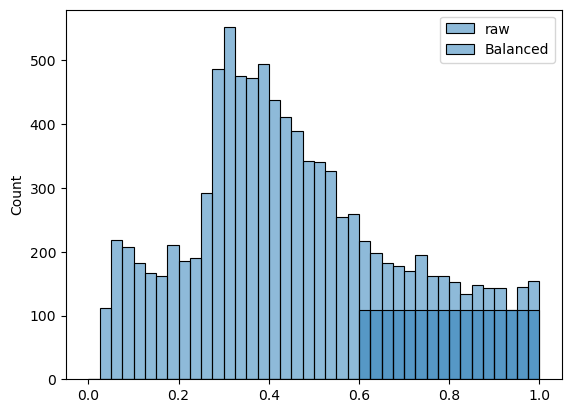

In [3]:
def get_filenames(dimension, simulation, simmetry, score):
    if os.getcwd().split('\\')[2] == 'lucas':
        score_filename = 'E:/Lucas GAN/Dados/4- Mechanical_scores/%s/%sD/%s/%s.csv' %(simulation,dimension,simmetry,score)
        geom_epoch_dirs = 'E:/Lucas GAN/Dados/7- Perfomance_data/%sD/geom_epoch/%s/%s/' %(dimension,simmetry,score)
        gif_filename = 'E:/Lucas GAN/Dados/7- Perfomance_data/%sD/geom_epoch/%s/%s.gif' %(dimension,simmetry,score)
        tmp_models_dir = 'C:/Users/lucas/OneDrive/Documentos/GitHub/INT/Manufatura Aditiva/Simulacao-GAN/Pipeline/3- Machine_learning/GAN/tmp_models/GAN/'
        models_dir = 'D:/Lucas GAN/Dados/5- Models/cGAN/%sD/%s/%s/'%(dimension,simmetry,score)
        arrays_dir = 'E:/Lucas GAN/Dados/1- Arranged_geometries/GAN/%s/%s/' % (simmetry,score)
    else:
        score_filename = 'D:/Lucas GAN/Dados/4- Mechanical_scores/%s/%sD/%s/%s.csv' %(simulation,dimension,simmetry,score)
        geom_epoch_dirs = 'D:/Lucas GAN/Dados/7- Perfomance_data/%sD/geom_epoch/%s/%s/' %(dimension,simmetry,score)
        gif_filename = 'D:/Lucas GAN/Dados/7- Perfomance_data/%sD/geom_epoch/%s/%s.gif' %(dimension,simmetry,score)
        tmp_models_dir = 'C:/Users/lucas.barbosa/Documents/GitHub/INT/Manufatura Aditiva/Simulacao-GAN/Pipeline/3- Machine_learning/GAN/tmp_models/GAN/'
        models_dir = 'D:/Lucas GAN/Dados/5- Models/GAN/%sD/%s/%s/'%(dimension,simmetry,score)
        arrays_dir = 'D:/Lucas GAN/Dados/1- Arranged_geometries/GAN/%s/%s/' % (simmetry,score)


    return score_filename, geom_epoch_dirs, gif_filename, tmp_models_dir, models_dir, arrays_dir

def load_data(score_filename, cutoff, bins, soft=False, balance=False, plot=False):  
    def find_closest(arr, val):
       idx = np.abs(arr - val).argmin()
       return arr[idx]
    data = np.loadtxt(score_filename,delimiter=',')
    X = data[:,1:-1]
    size = int(np.sqrt(X.shape[1]))
    X = X.reshape((X.shape[0],size,size,1))

    y = data[:,-1]
    y = y.reshape((y.shape[0],1))
    y = y[np.argsort(y[:,0])]
    total_size = y.shape[0]

    if plot:
        sns.histplot(y, legend=True, bins=bins, color='b')
    
    cutoff = find_closest(bins,cutoff)
    idxs_good = np.where(y>cutoff)[0]
    y = y[idxs_good]
    X = X[idxs_good]
    min_bin = idxs_good.shape[0]

    if balance:
        bins_good = bins[np.where(bins>=cutoff)]
        for i in range(len(bins_good)-1):
            l,u = bins_good[i:i+2]
            idx_bin = np.where((y>=l) & (y<u))[0]
            y_bin = y[idx_bin]
            min_bin = min(min_bin,y_bin.shape[0])

        X_balanced = np.zeros((min_bin*(bins_good.shape[0]-1),X.shape[1],X.shape[2],X.shape[3]))
        y_balanced = np.zeros((min_bin*(bins_good.shape[0]-1),1))
        y_ = np.ones((min_bin*(bins_good.shape[0]-1),1))

        for i in range(len(bins_good)-1):
            l,u = bins_good[i:i+2]
            idx_bin = np.where((y>=l) & (y<u))[0]
            X_bin = X[idx_bin]
            y_bin = y[idx_bin]

            idx_bin = np.random.choice(y_bin.shape[0],min_bin)
            X_bin = X_bin[idx_bin]
            y_bin = y_bin[idx_bin]

            X_balanced[min_bin*i:min_bin*(i+1)] = X_bin
            y_balanced[min_bin*i:min_bin*(i+1)] = y_bin

        X = X_balanced
        y = y_

        if plot:
            sns.histplot(y_balanced, legend=True, bins=bins, color='r')

    if soft:
        y = np.random.choice(np.linspace(0.7,1.2,6)).round(1)*np.ones(y.shape)
    
    plt.legend(['raw','Balanced'])
    
    print(f"Good = %.2f %%"%(100*len(y)/total_size))
    
    return X, y, size

dimension = 2
simulation = '-r'
simulation = {'-m':'MATLAB','-r':'RTGA'}[simulation]
simmetry = 'p4m'
score = 'isotropy'
score_filename,_,_,_,_,_ = get_filenames(dimension, simulation, simmetry, score)

cutoff = 0.6
bins= np.linspace(0,1,41).round(3)
soft = False
plot = True
balance = True

X, y, size = load_data(score_filename, cutoff, bins, soft=soft, balance=balance, plot=plot)

# Models definition

## Generator

Model: "Generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 G-Latent-Input (InputLayer)  [(None, 128)]            0         
                                                                 
 G-FoundationLayer (Dense)   (None, 8192)              1056768   
                                                                 
 G-ReshapeLayer (Reshape)    (None, 8, 8, 128)         0         
                                                                 
 G-HiddenLayer1 (Conv2DTrans  (None, 16, 16, 128)      262272    
 pose)                                                           
                                                                 
 G-Geometry-Output (Conv2D)  (None, 16, 16, 1)         8193      
                                                                 
Total params: 1,327,233
Trainable params: 1,327,233
Non-trainable params: 0
_______________________________________________

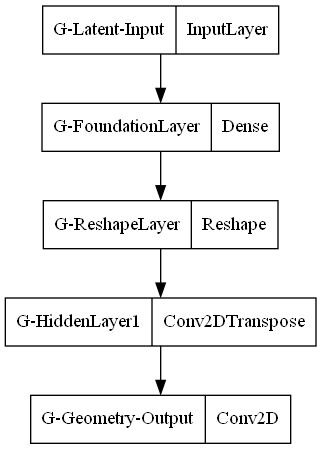

In [4]:
def setup_G(input_G,output_G,size):
    size = int(size/2)
    in_G = Input(shape=(input_G,),name="G-Latent-Input")

    # foundation for 8x8 image
    n_nodes = input_G * size * size
    out_G = Dense(n_nodes,activation=LeakyReLU(alpha=0.2),name="G-FoundationLayer")(in_G)
    out_G = Reshape((size, size, 128),name="G-ReshapeLayer")(out_G)
    # upsample to 16x16
    out_G = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same',activation=LeakyReLU(alpha=0.2),name="G-HiddenLayer1")(out_G)
    out_G = Conv2D(1, (size,size), activation='sigmoid', padding='same',name="G-Geometry-Output")(out_G)

    # model = Model(name='Generator',inputs=in_G,outputs=[out_G,out_porosity,out_validity])
    model = Model(name='Generator',inputs=in_G,outputs=[out_G])
    return model
G_test = setup_G(128,256,16)
G_test.summary()
tf.keras.utils.plot_model(G_test)

## Discriminator

Model: "Discriminator"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 D-Geometry-Input (InputLayer)  [(None, 16, 16, 1)]  0           []                               
                                                                                                  
 D-NoiseLayer1 (GaussianNoise)  (None, 16, 16, 1)    0           ['D-Geometry-Input[0][0]']       
                                                                                                  
 D-HiddenLayer1 (Conv2D)        (None, 8, 8, 64)     640         ['D-NoiseLayer1[0][0]']          
                                                                                                  
 D-InstanceNormalization-Layer1  (None, 8, 8, 64)    2           ['D-HiddenLayer1[0][0]']         
  (InstanceNormalization)                                                             

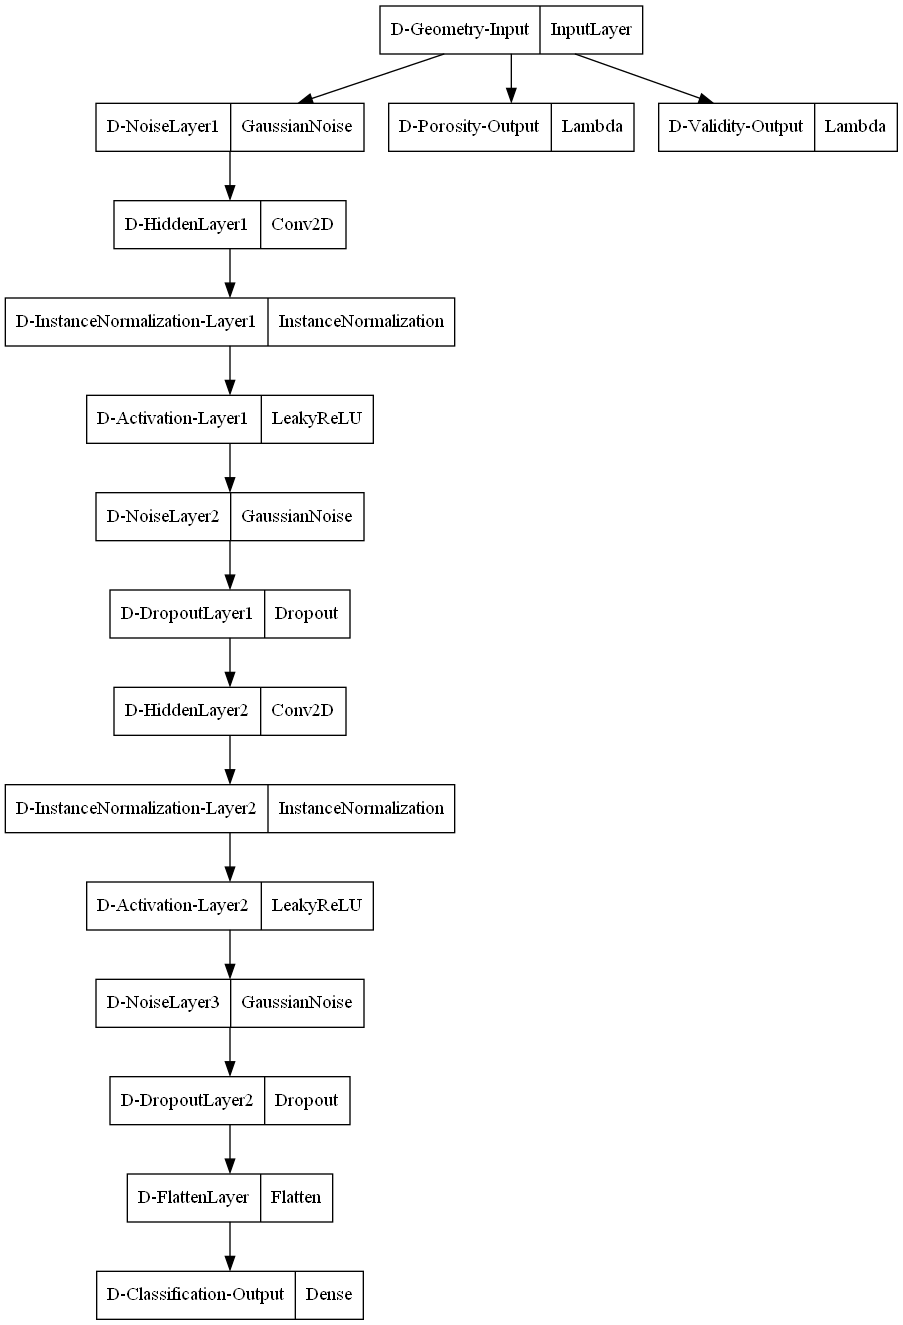

In [5]:
def wasserstein_loss():
    def custom_loss(y_true, y_pred):
	    return K.mean(y_true * y_pred)
    return custom_loss

def porosity_loss():
    def custom_por_loss(y_true,y_pred):
        # size = y_pred.shape[1]*y_pred.shape[2]
        y_pred = K.round(y_pred)
        por_true = K.sum(K.sum(K.sum(y_true,axis=1),axis=1),axis=1)
        por_pred = K.sum(K.sum(K.sum(y_pred,axis=1),axis=1),axis=1)
        mse = tf.cast((por_true-por_pred)**2,tf.float32)
        return mse
    return custom_por_loss

def validity_loss():
    def custom_val_loss(y_true, y_pred):
        # @tf.function
        def connectivity_losss(element):
            size = element.shape[0]
            element = element.numpy().reshape((size,size))
            labels = measure.label(element,connectivity=1)
            return len(np.unique(labels))

        def simmetry_loss(element):
           return 0
            
        y_pred = K.round(y_pred)
        con_loss = tf.map_fn(fn=connectivity_losss, elems=y_pred)
        if simmetry[1:] in ['4m','4g']:
            sim_loss = tf.map_fn(fn=simmetry_loss, elems=y_pred)
            return con_loss + sim_loss
        return con_loss

    return custom_val_loss
    
def setup_D(input_D,loss,lr,alpha_por,alpha_val,normalize=False):
    #define model
    in_D = Input(shape=input_D,name="D-Geometry-Input")

    out_D = GaussianNoise(0.1,name="D-NoiseLayer1")(in_D)
    out_D = Conv2D(64, (3,3), strides=(2, 2), padding='same',name="D-HiddenLayer1")(out_D)
    if normalize:
        out_D = InstanceNormalization(name="D-InstanceNormalization-Layer1")(out_D)
    out_D = LeakyReLU(alpha=0.2,name="D-Activation-Layer1")(out_D)

    out_D = GaussianNoise(0.1,name="D-NoiseLayer2")(out_D)
    out_D = Dropout(0.4,name="D-DropoutLayer1")(out_D)
    out_D = Conv2D(64, (3,3), strides=(2, 2), padding='same',name="D-HiddenLayer2")(out_D)
    if normalize:
        out_D = InstanceNormalization(name="D-InstanceNormalization-Layer2")(out_D)
    out_D = LeakyReLU(alpha=0.2,name="D-Activation-Layer2")(out_D)

    out_D = GaussianNoise(0.1,name="D-NoiseLayer3")(out_D)
    out_D = Dropout(0.4,name="D-DropoutLayer2")(out_D)
    out_D = Flatten(name="D-FlattenLayer")(out_D)
    out_D = Dense(1, activation='sigmoid',name="D-Classification-Output")(out_D)

    # porosity branch
    out_porosity = Lambda(lambda x: x,name='D-Porosity-Output')(in_D)

    # validity branch
    out_validity = Lambda(lambda x: x,name='D-Validity-Output')(in_D)

    opt = Adam(learning_rate=lr, beta_1=0.5)
    
    model = Model(
                name='Discriminator', \
                # inputs=[in_D,in_porosity,in_validity], \
                inputs=[in_D], \
                outputs=[out_D,out_porosity,out_validity])

    loss_func = {'bce':'binary_crossentropy','wl':wasserstein_loss,'kld':kullback_leibler_divergence}[loss]
    model.compile(
                loss=[loss_func,porosity_loss(),validity_loss()], \
                loss_weights=[1.0,0.0,0.0], \
                optimizer='adam', \
                metrics=['accuracy'], \
                run_eagerly=True)
    return model

D_test = setup_D((16,16,1),'bce',1e-4,0.01,0.01,True)
D_test.summary()
tf.keras.utils.plot_model(D_test)

## Setup GAN

In [6]:
def setup_GAN(G_model,D_model,loss,alpha_por,alpha_val,lr,size):
    D_model.trainable = False
    in_G = G_model.input
    out_GAN = D_model(G_model(in_G))
    
    opt = Adam(learning_rate=lr, beta_1=0.5)
    
    model = Model(name='GAN',inputs=in_G,outputs=out_GAN)
    loss_func = {'bce':'binary_crossentropy','wl':wasserstein_loss,'kld':kullback_leibler_divergence}[loss]
    model.compile(
                loss=[loss_func,porosity_loss(),validity_loss()], \
                loss_weights=[1.0,alpha_por,alpha_val], \
                optimizer='adam', \
                metrics=['accuracy'], \
                run_eagerly=True)
    return model

setup_GAN(setup_G(128,256,16),setup_D((16,16,1),'bce',1e-4,0.01,0.01),'bce',0.01,0.01,1e-4,16).summary()

Model: "GAN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 G-Latent-Input (InputLayer)  [(None, 128)]            0         
                                                                 
 Generator (Functional)      (None, 16, 16, 1)         1327233   
                                                                 
 Discriminator (Functional)  [(None, 1),               38593     
                              (None, 16, 16, 1),                 
                              (None, 16, 16, 1)]                 
                                                                 
Total params: 1,365,826
Trainable params: 1,327,233
Non-trainable params: 38,593
_________________________________________________________________


# Aux functions

## For geometry manipulation

In [7]:
def create_unit(element,size,simmetry):
  if simmetry[1:2] == '4':
    unit_size = 2*size
    # fold_size = np.random.choice(4,1)[0]
    unit = np.ones((2*size,2*size))*(-1)
    h,w = element.shape
    for i in range(h):
      for j in range(w):
        el = element[i,j]
        
        j_ = [j,w-1-i,2*h-1-j,i+w]
        i_ = [i+w,j,w-1-i,2*h-1-j]
        # (1,7)->(7,14)->(14,8)->(8,1)
        for (k,l) in list(zip(i_,j_)):
          unit[k,l]  = el
    return unit

def create_arrange(unit,rows,cols):
  size = unit.shape[0]
  arrange = np.zeros((rows*size,cols*size))
  for i in range(unit.shape[0]):
    for j in range(unit.shape[1]):
      for row in range(rows):
        for col in range(cols):
          arrange[j+row*size,i+col*size] = unit[j,i]
  
  return arrange

def get_porosity(geom):
    voids = np.where(geom == 0.0)[0].shape[0]

    return voids/(geom.shape[0]*geom.shape[1])

## For GAN

In [8]:
def generate_fake_samples(G_model, input_G, n_samples, method):
    # generate points in latent space
    X_input = generate_input_G(input_G, n_samples,method)
    # predict outputs
    X = G_model.predict(X_input,verbose = 0)
    # create 'fake' class labels (0)
    y = np.zeros((n_samples, 1))
    return X,y

def generate_input_G(input_G, n_samples, method):

    if method == 'normal':
        # generate points in the latent space
        X_input = np.random.randn(input_G * n_samples)
        # reshape into a batch of inputs for the network
        X_input = X_input.reshape(n_samples, input_G)
    if method == 'uniform':
        X_input = np.random.uniform(n_samples,input_G)
    if method == 'spherical':
        X_input = np.random.randn(input_G * n_samples)
        # reshape into a batch of inputs for the network
        X_input = X_input.reshape(n_samples, input_G)
        X_input /= np.linalg.norm(X_input, axis=0)/3.0
    return X_input

def generate_real_samples(dataset, y, n_samples):
    # choose random instances
    idx = np.random.randint(0, dataset.shape[0], n_samples)
    # retrieve selected images
    X = dataset[idx]
    # generate 'real' class labels (1)
    y = y[idx]
    return X, y

def summarize_performance(epoch,porosity,G_model, D_model, dataset, y, input_G, sampling_method, n_samples=100):
    # prepare real samples
    X_real, y_real = generate_real_samples(dataset, y, n_samples)
    # evaluate discriminator on real examples
    _,_,_,_,acc_real,_,_ = D_model.evaluate(x=[X_real], y=[y_real,porosity*np.ones(X_real.shape),np.zeros(X_real.shape)], verbose=0)
    # prepare fake examples
    X_fake, y_fake = generate_fake_samples(G_model, input_G, n_samples, sampling_method)
    # evaluate discriminator on fake examples
    _,_,_,_,acc_fake,_,_ = D_model.evaluate(x=[X_fake], y=[y_fake,porosity*np.ones(X_fake.shape),np.zeros(X_fake.shape)], verbose=0)
    # summarize discriminator performance
    return  acc_real,acc_fake

# Filter per porosity
def porosity_match(geoms,porosity,tol):
    geoms_ = []
    passed = 0
    for i in range(geoms.shape[0]):
        g =geoms[i,:,:,0]
        size = g.shape[0]
        g = g.reshape((size*size,))
        p = 1 - np.sum(g)/(size*size)
        if p >= porosity-tol and p <= porosity+tol:
            geoms_.append(g.reshape((size,size)))
            passed += 1
    return passed/len(geoms),np.array(geoms_).reshape((passed,size,size,1))

# Training GAN

In [40]:
def train_GAN(X, y, G_model, D_model, GAN_model, input_G, porosity, tol_porosity, batch_size, num_epochs, sampling_method, tmp_models_dir, geom_epoch_dirs, seed_geom_gif, tol_fail, alpha_por, alpha_val, vstack=True, save=True, plot=False, verbose_loss=False, verbose_acc=False):
    def train_D(X,y,half_batch):
        if vstack:
            X_real,y_real = generate_real_samples(X,y,half_batch)
            X_fake,y_fake = generate_fake_samples(G_model,input_G,half_batch,sampling_method)            

            X, y = np.vstack((X_real, X_fake)), np.vstack((y_real, y_fake))
            
            if verbose_loss:
                D_loss = D_model.train_on_batch(x=[X], y=[y,porosity*np.ones(X.shape),0*np.ones(X.shape)],return_dict=True)
                D_loss = D_loss['loss']
            else:
                D_loss = D_model.train_on_batch(x=[X], y=[y,porosity*np.ones(X.shape),0*np.ones(X.shape)])
                D_loss = D_loss[0]

        else:
            X_real,y_real = generate_real_samples(X,y,half_batch)
            X_fake,y_fake = generate_fake_samples(G_model,input_G,half_batch,sampling_method)            

            if verbose_loss:
                D_loss_real = D_model.train_on_batch(x=[X_real], y=[y_real,porosity*np.ones(X_real.shape),0*np.ones(X_real.shape)],return_dict=True)
                D_loss_real = D_loss_real['loss']
                D_loss_fake = D_model.train_on_batch(x=[X_fake], y=[y_fake,porosity*np.ones(X_fake.shape),0*np.ones(X_fake.shape)],return_dict=True)
                D_loss_fake = D_loss_fake['loss']
            else:
                D_loss_real = D_model.train_on_batch(x=[X_real], y=[y_real,porosity*np.ones(X_real.shape),0*np.ones(X_real.shape)])
                D_loss_real = D_loss_real[0]
                D_loss_fake = D_model.train_on_batch(x=[X_fake], y=[y_fake,porosity*np.ones(X_fake.shape),0*np.ones(X_fake.shape)])
                D_loss_fake = D_loss_fake[0]

            D_loss = (D_loss_real+D_loss_fake)/2
            

        return D_loss

    def swap_weights(tmp_models_dir):
        D_files = os.listdir(tmp_models_dir+'/D/')
        D_file = np.random.choice(D_files,1)[0]
        D_model_swap = load_model(tmp_models_dir+'/D/'+D_file, custom_objects={'custom_por_loss':porosity_loss(),'custom_val_loss':validity_loss(),'InstanceNormalization':InstanceNormalization()})
        return (D_files.index(D_file)+1)*5, D_model_swap.get_weights()
    
    def reset_weights(weights_shape):
        return [np.random.random(x) for x in weights_shape] 

    def train_G(X_shape,alpha_por,alpha_val):
        X_GAN = generate_input_G(input_G, batch_size, sampling_method)
        y_GAN = np.ones((batch_size, 1))

        if verbose_loss:
            G_loss_list = GAN_model.train_on_batch(x=X_GAN, y=[y_GAN,porosity*np.ones(X_shape),0*np.ones(X_shape)],return_dict=True)
            idxs = list(G_loss_list.keys())
        else:
            G_loss_list = GAN_model.train_on_batch(x=X_GAN, y=[y_GAN,porosity*np.ones(X_shape),0*np.ones(X_shape)])
            idxs = [0,1,2,3]

        G_total_loss = G_loss_list[idxs[0]]
        G_loss = G_loss_list[idxs[1]]
        G_por_loss = alpha_por*G_loss_list[idxs[2]]
        G_val_loss = alpha_val*G_loss_list[idxs[3]]

        return G_total_loss,G_loss,G_por_loss,G_val_loss

    def clean_tmp_models(tmp_models_dir):
        for file in os.listdir(tmp_models_dir+'G/'):
            os.remove(tmp_models_dir+'G/'+file)

        for file in os.listdir(tmp_models_dir+'D/'):
            os.remove(tmp_models_dir+'D/'+file)

        for geom_file in os.listdir(geom_epoch_dirs):
            os.remove(geom_epoch_dirs+geom_file)

    # remove previous tmp models files
    if save:
        clean_tmp_models(tmp_models_dir)
    
    weights_shape = [x.shape for x in D_model.get_weights()]
    batch_per_epoch = int(X.shape[0] /batch_size)
    half_batch = int(batch_size/2)
    
    G_losses = []
    G_por_losses = []
    G_val_losses = []
    D_losses = []

    accs_real = []
    accs_fake = []
    pors_match = []
    stds = []
    
    fig,ax = plt.subplots(1,3);
    fig.set_size_inches((24,8))

    epoch_count = 0
    while epoch_count < num_epochs:
        G_losses_epoch = []
        G_por_losses_epoch = []
        G_val_losses_epoch = []
        D_losses_epoch = []
        batch_count = 0
        while batch_count < batch_per_epoch:
            # train D
            D_loss = train_D(X,y,half_batch)

            # check failure mode
            D_losses_epoch.append(D_loss)

            # train G
            G_total_loss,G_loss,G_por_loss,G_val_loss = train_G((batch_size,X.shape[1],X.shape[2],X.shape[3]),alpha_por,alpha_val)
            G_losses_epoch.append(G_loss)
            G_por_losses_epoch.append(G_por_loss)
            G_val_losses_epoch.append(G_val_loss)

            if verbose_loss: 
                print('>%d, %d/%d, D_loss=%.3f, G_loss=%.3f' % (epoch_count+1, batch_count+1, batch_per_epoch,  D_loss, G_total_loss))
            
            batch_count += 1
        
        epoch_count +=1 
            
        G_losses.append(np.array(G_losses_epoch).mean())
        G_por_losses.append(np.array(G_por_losses_epoch).mean())
        G_val_losses.append(np.array(G_val_losses_epoch).mean())
        D_losses.append(np.array(D_losses_epoch).mean())

        # check failure modes
        if D_losses[-1] <= tol_fail:
            weights = reset_weights(weights_shape)
            D_model.set_weights(weights)
            print('Failure Mode 1: reseting D model')

        elif np.std(D_losses[-5:])<=tol_fail and epoch_count >= 10:
            epoch, weights = swap_weights(tmp_models_dir)
            D_model.set_weights(weights)
            print('Failure Mode 2: swapping to D model of epoch %d'%epoch)
            
        # export model
        if epoch_count % 5 == 0:
            acc_real,acc_fake = summarize_performance(epoch_count,porosity,G_model,D_model,X,y,input_G,sampling_method)
            accs_real.append(acc_real)
            accs_fake.append(acc_fake)

            X_test = generate_input_G(input_G,1000,sampling_method)
            geoms = G_model.predict(X_test, verbose=0)
            geoms = np.array(geoms)
            por_match,_ = porosity_match(geoms, porosity, tol_porosity)
            pors_match.append(por_match)

            score = D_model.predict([geoms],verbose=0)[0]
            std = score.std()
            stds.append(std)

            if save:
                G_model.save(tmp_models_dir+'/G/epoch_%03d_por_%.2f_std_%.2f.h5'%(epoch_count, por_match, std))
                D_model.save(tmp_models_dir+'/D/epoch_%03d_real_%.2f_fake_%.2f.h5'%(epoch_count, acc_real, acc_fake))
                
            if verbose_acc:
                os.system('cls')
                print('>Epoch: %i Porosity match: %.0f%% Std: %.2f real: %.0f%% fake: %.0f%%' % (epoch_count,  por_match*100, std, acc_real*100, acc_fake*100))

        # save geometry
        if epoch_count % 5 == 0:
            geom_gif_filename = geom_epoch_dirs + 'epoch_%03d.png'%(epoch_count)
            elem_gif = G_model.predict(seed_geom_gif, verbose=0)
            size = elem_gif.shape[1]
            elem_gif = elem_gif.reshape((size,size))
            ax[0].imshow(elem_gif,cmap='Greys');
            ax[0].axis('off')

            unit_gif = create_unit(elem_gif,size,'p4') 
            ax[1].imshow(unit_gif,cmap='Greys');
            ax[1].axis('off')

            arrange_gif = create_arrange(unit_gif,3,3)
            ax[2].imshow(arrange_gif,cmap='Greys');
            ax[2].axis('off')
            plt.savefig(geom_gif_filename, bbox_inches='tight')
    
    G_losses = np.array(G_losses)
    G_por_losses = np.array(G_por_losses)
    G_val_losses = np.array(G_val_losses)
    D_losses = np.array(D_losses)

    if plot:
        plt.figure(figsize=((10,8)))
        plt.plot(list(range(1,num_epochs+1)),D_losses,label='D Loss')
        plt.title('Loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.plot(list(range(1,num_epochs+1)),G_losses,label='G Loss')
        plt.plot(list(range(1,num_epochs+1)),G_por_losses,label='Porosity loss')
        plt.plot(list(range(1,num_epochs+1)),G_val_losses,label='Validity loss')
        plt.legend()
        plt.show()

        fig, ax = plt.subplots(3)
        fig.tight_layout(pad=0.75)
        fig.set_size_inches((10,8))
        ax[0].plot(list(range(1,num_epochs+1,5)),accs_fake,label='Accuracy fake')
        ax[0].set_xlabel('Epoch')
        ax[0].plot(list(range(1,num_epochs+1,5)),accs_real,label='Accuracy real')
        ax[0].legend()

        ax[1].plot(list(range(1,num_epochs+1,5)),pors_match)
        ax[1].set_title('Porosity match')
        ax[1].set_xlabel('Epoch')
        
        ax[2].plot(list(range(1,num_epochs+1,5)),stds)
        ax[2].set_title('Std dev')
        ax[2].set_xlabel('Epoch')
        ax[1].legend()
        plt.show()

Good = 8.85 %
>1, 1/13, D_loss=1.337, G_loss=2.582
>1, 2/13, D_loss=0.870, G_loss=2.346
>1, 3/13, D_loss=0.678, G_loss=2.879
>1, 4/13, D_loss=0.726, G_loss=2.595
>1, 5/13, D_loss=0.634, G_loss=2.682
>1, 6/13, D_loss=0.557, G_loss=2.930
>1, 7/13, D_loss=0.542, G_loss=3.365
>1, 8/13, D_loss=0.414, G_loss=3.837
>1, 9/13, D_loss=0.233, G_loss=4.330
>1, 10/13, D_loss=0.178, G_loss=4.676
>1, 11/13, D_loss=0.113, G_loss=5.972
>1, 12/13, D_loss=0.083, G_loss=7.616
>1, 13/13, D_loss=0.074, G_loss=11.888
>2, 1/13, D_loss=0.082, G_loss=15.382
>2, 2/13, D_loss=0.222, G_loss=18.361
>2, 3/13, D_loss=0.935, G_loss=18.883
>2, 4/13, D_loss=1.387, G_loss=19.615
>2, 5/13, D_loss=1.532, G_loss=20.355
>2, 6/13, D_loss=1.166, G_loss=20.925
>2, 7/13, D_loss=0.514, G_loss=22.176
>2, 8/13, D_loss=0.367, G_loss=23.200
>2, 9/13, D_loss=0.283, G_loss=24.502
>2, 10/13, D_loss=0.428, G_loss=25.619
>2, 11/13, D_loss=0.242, G_loss=25.643
>2, 12/13, D_loss=0.232, G_loss=26.007
>2, 13/13, D_loss=0.106, G_loss=25.411
>3

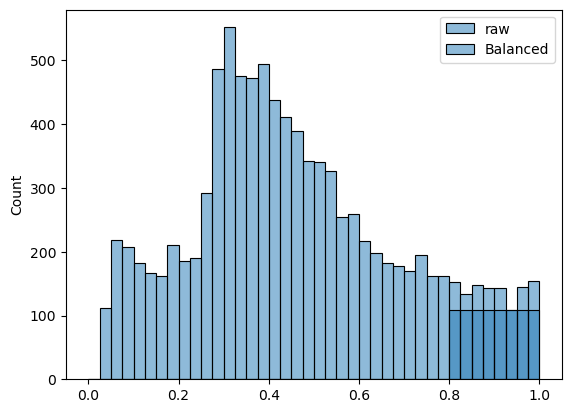

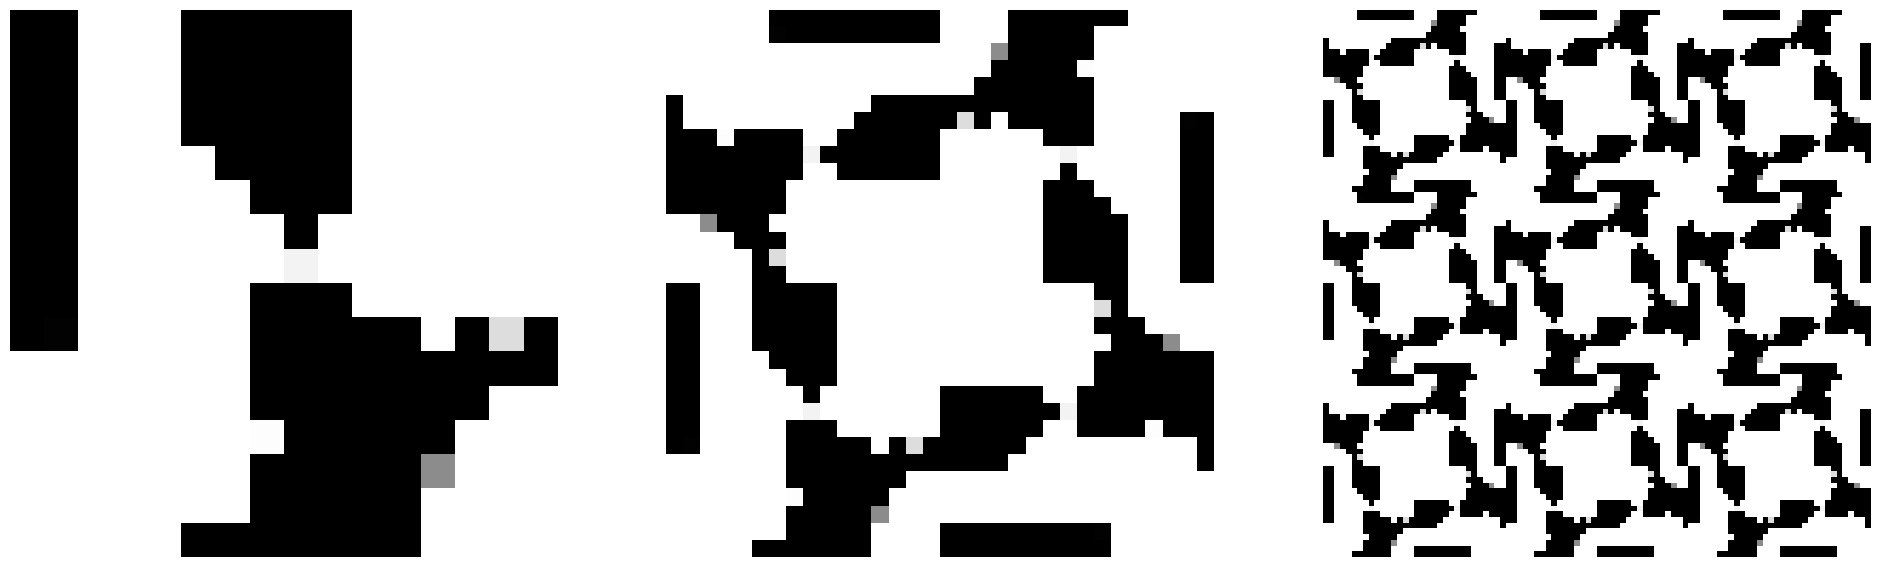

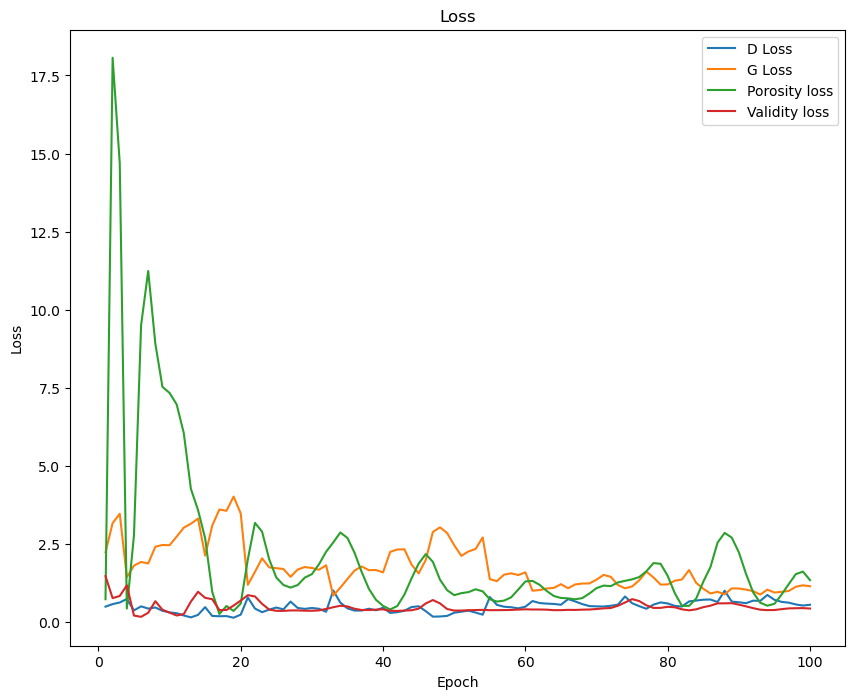

ValueError: x and y must have same first dimension, but have shapes (10,) and (20,)

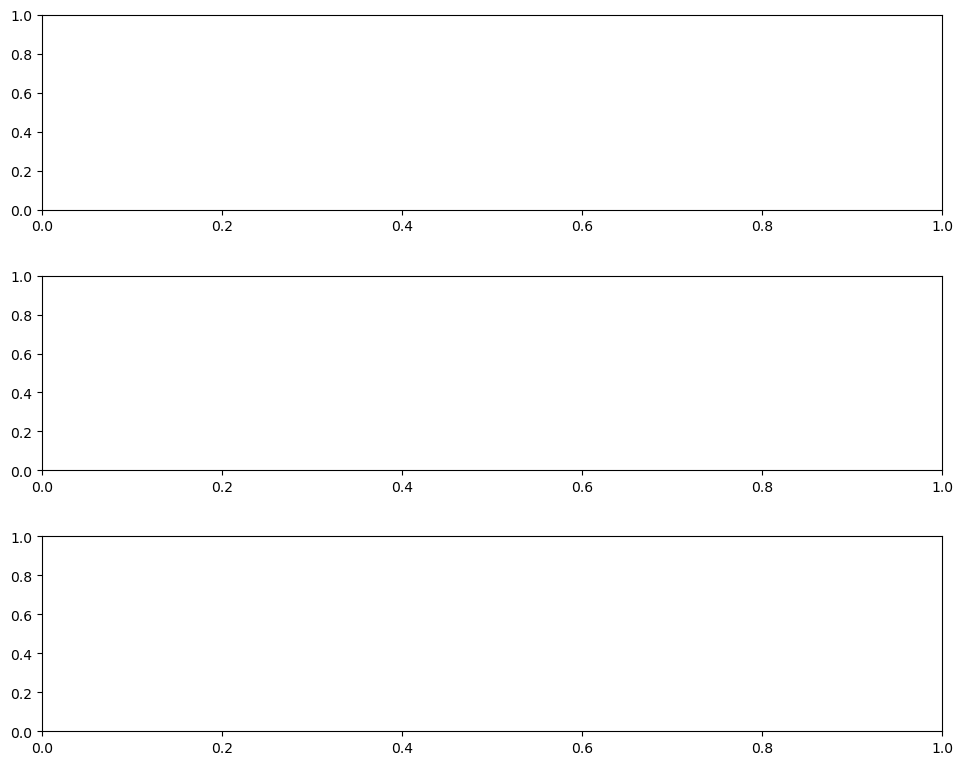

In [41]:
# data origin parameters
dimension = 2
simulation = '-r'
simulation = {'-m':'MATLAB','-r':'RTGA'}[simulation]
simmetry = 'p4m'
score = 'isotropy'

# data processing parameters
score_filename, geom_epoch_dirs, gif_filename, tmp_models_dir, models_dir, arrays_dir = get_filenames(dimension, simulation, simmetry, score)
cutoff = 0.8
bins= np.linspace(0,1,41).round(3)
soft = False
plot = True
balance = True
X, y, size = load_data(score_filename, cutoff, bins, soft=soft, balance=balance, plot = plot)

# GAN dimensions
input_G = 128
output_G = input_D = X.shape[1:]
output_D = 1

# training parameters
num_epochs = 100
batch_size = 64
sampling_method = 'normal'
loss = 'bce' 
lr = 1e-4 
alpha_por = 1e-3 #2e-4
alpha_val = 1e-1 #8e-2
vstack=False

# style loss parameters
porosity = 0.55
tol_porosity = 0.02
tol_fail = 5e-2

# setup models
G = setup_G(input_G,output_G,size)
normalize=True
D = setup_D(input_D,loss,lr,alpha_por,alpha_val,normalize)
GAN = setup_GAN(G,D,loss,alpha_por,alpha_val,lr,size)

# metrics paramaters
plot=True
save=True
verbose_loss=True
verbose_acc=True

seed_geom_gif = np.random.randn(input_G).reshape(1, input_G)
train_GAN(X,y,G,D,GAN,input_G,porosity,tol_porosity,batch_size,num_epochs,sampling_method,tmp_models_dir,geom_epoch_dirs,seed_geom_gif,tol_fail,alpha_por, alpha_val, save=save, vstack=vstack,plot=plot,verbose_loss=verbose_loss,verbose_acc=verbose_acc)

# Evaluate `Generator`

## Compile gif

In [26]:
score_filename, geom_epoch_dirs, gif_filename, tmp_models_dir, models_dir, arrays_dir = get_filenames(dimension, simulation, simmetry, score)

with imageio.get_writer(gif_filename, mode='I') as writer:
    geom_filenames = os.listdir(geom_epoch_dirs)
    for geom_filename in geom_filenames:
        image = imageio.imread(geom_epoch_dirs+geom_filename)
        foo = cv2.putText(
                    image,
                    str((geom_filenames.index(geom_filename)+1)*5),
                    (5, 25),
                    cv2.FONT_HERSHEY_SIMPLEX,
                    1,
                    (255, 0, 0),
                    2)
        for i in range(3):
            # image = imageio.imread(geom_epoch_dirs+geom_filename)
            writer.append_data(image)

## Visualize geometries

In [49]:
def check_unit(unit, desired_porosity, tol):
  labels = measure.label(unit,connectivity=1)
  main_label = 0
  main_label_count = 0
  passed = True

  element = unit[int(unit.shape[0]/2):,:int(unit.shape[0]/2)]

  for label in range(1,len(np.unique(labels))):
      label_count = np.where(labels==label)[0].shape[0]
      if label_count > main_label_count:
        main_label = label
        main_label_count = label_count

  void_count = 0

  for label in range(1,len(np.unique(labels))):
    if label not in [0,main_label]:
      void_count += np.where(labels==label)[0].shape[0]
      unit[np.where(labels==label)] = 0.

  porosity = get_porosity(unit)

  if porosity > desired_porosity - tol and porosity < desired_porosity + tol:
    for label in range(1,len(np.unique(labels))):
      if label not in [0,main_label]:
        unit[np.where(labels==label)] = 0.

    if unit[0,:].sum() > 0 and unit[:,0].sum() > 0:
      # check if there is connectivity right-left
      connections_rl = 0
      for i in range(unit.shape[0]):
        if (unit[i,0] == 1 and unit[i,-1] == 1):
          connections_rl += 1

      # check if there is connectivity top-bottom
      connections_tb = 0
      for j in range(unit.shape[1]):
        if (unit[0,j] == 1 and unit[-1,j] == 1):
          connections_tb += 1

      if connections_rl == 0 or connections_tb == 0:
        passed = False
      
    else:
      passed = False
      
  else:
    passed = False

  if passed:
    passed = False
    for i in range(element.shape[0]):
      if [element[i,0],element[element.shape[0]-1,element.shape[1]-i-1]]==[1,1]:
        passed = True

  return passed, element

def check_singularity(element, simmetry):
  passeds = [True for i in range(4)]

  # check singularities inside element
  for i in range(element.shape[0]-1):
    for j in range(element.shape[1]-1):
      # print(element[i:i+2,j:j+2])
      diag1 = list(element[i:i+2,j:j+2].diagonal())
      diag2 = list(np.fliplr(element[i:i+2,j:j+2]).diagonal())
      if (diag1 == [1,1] and diag2 == [0,0]) or (diag1 == [0,0] and diag2 == [1,1]):
        passeds[0] = False    

  # check singularities in element boundary and singularities in unit boundary
  if simmetry[1:] == '4':
    for j in range(element.shape[1]-1):
      arr = np.array([[element[element.shape[0]-j-1,element.shape[1]-1],element[element.shape[0]-j-2,element.shape[1]-1]],[element[0,j],element[0,j+1]]])
      diag1 = list(arr.diagonal())
      diag2 = list(np.fliplr(arr).diagonal())
      if (diag1 == [1,1] and diag2 == [0,0]) or (diag1 == [0,0] and diag2 == [1,1]):
        passeds[1] = False
      
      arr = np.array([[element[element.shape[0]-1,j],element[element.shape[0]-1,j+1]],[element[j,0],element[j+1,0]]])
      diag1 = list(arr.diagonal())
      diag2 = list(np.fliplr(arr).diagonal())
      if (diag1 == [1,1] and diag2 == [0,0]) or (diag1 == [0,0] and diag2 == [1,1]):
        passeds[2] = False
      if [element[0,0],element[element.shape[0]-1,element.shape[1]-1]] == [1, 0] or [element[0,0],element[element.shape[0]-1,element.shape[1]-1]] == [0, 1]:
        passeds[3] = False

  return passeds


def save_models(epoch_G,epoch_D,save,tmp_models_dir,models_dir):
  # select model
  G_files = os.listdir(tmp_models_dir+'/G/')
  for i in range(len(G_files)):
    G_file = G_files[i]
    if int(G_file.split('_')[1]) == epoch_G:
      G = load_model(tmp_models_dir+'/G/'+G_file)
      break

  D_files = os.listdir(tmp_models_dir+'/D/')
  for i in range(len(D_files)):
    D_file = D_files[i]
    if int(D_file.split('_')[1]) == epoch_D:
      D = load_model(tmp_models_dir+'/D/'+D_file, custom_objects={'custom_por_loss':porosity_loss(),'custom_val_loss':validity_loss(),'InstanceNormalization':InstanceNormalization()})
      break

  if save: 
      models_filename = os.listdir(models_dir)
      models_filename = ['_'.join(x.split('_')[1:]) for x in models_filename]
      if G_file not in models_filename:
        idx_model = len(models_filename)+1
        G.save(models_dir+'%04d_'%(idx_model)+G_file)
      else:
        # find idx of existing model
        idx_model = models_filename.index(G_file)+1
  else:
    idx_model = None
  return G, D, idx_model


def generate_geometries(test_size, rounds, idx_model, top, tol, desired_porosity, save, plot):
  idx = len(os.listdir(arrays_dir))+1
  for r in range(rounds):
    X_test = generate_input_G(input_G,test_size,sampling_method)
    geometries = G.predict(X_test,verbose = 0)
    size = geometries.shape[1]

    prepor_size = geometries.shape[0]
    
    if plot:
      fig,ax = plt.subplots(1,2);
      fig.set_size_inches((10,5));
      
      ax[0].set_title('Porosity Histogram')
      ax[0].set_ylabel('Frequency')
      porosities = 1-np.sum(geometries.round().reshape((test_size,int(size*size))),axis=-1)/int(size*size)
      sns.histplot(porosities,ax=ax[0],bins=32,stat="density");
    
    _, geometries = porosity_match(geometries, desired_porosity, tol)
    elements = []
    preval_size = geometries.shape[0]

    for i in range(len(geometries)):
      geom = geometries[i].reshape((size,size)).round()
      unit = create_unit(geom,size,simmetry)
      passed_connectivity,element = check_unit(unit, desired_porosity, tol)
      passed_singularity = check_singularity(element, simmetry)
      if passed_connectivity and all(passed_singularity):
        elements.append(element)

    geometries = np.array(elements)
    postval_size = geometries.shape[0]

    # Get scores
    scores = D.predict([geometries],verbose = 0)[0].ravel()

    if plot:
      ax[1].set_title('Score Histogram')
      ax[1].set_ylabel('Frequency')
      sns.histplot(scores,ax=ax[1],bins=32,stat="density");
      print('Avg porosity: %.2f. Avg score: %.2f Validity match: %.2f'%(porosities.mean(),scores.mean(),postval_size/preval_size))
      plt.show()

    top_idxs = np.argsort(-scores)[:top]

    for top_idx in top_idxs:
      elem = geometries[top_idx]
      unit = create_unit(elem.reshape((size,size)),size,simmetry)
      arrange = create_arrange(unit,3,3)
      
      if plot:
        print("Score: %.2f Porosity: %.2f"%(scores[top_idx],get_porosity(elem)))
        fig,ax = plt.subplots(1,3);
        fig.set_size_inches((15,5))
        
        ax[0].imshow(elem,cmap='Greys');
        ax[0].axis('off')
        
        ax[1].imshow(unit,cmap="Greys")
        ax[1].axis('off')

        ax[2].imshow(arrange,cmap="Greys")
        ax[2].axis('off')
        plt.show()

      if save:
        filename = arrays_dir+"%05d_model_%04d_porosity_%.4f.txt" % (idx, idx_model, 1.0-elem.ravel().sum()/(size*size))
        elem = elem.ravel()
        elem_ = np.zeros(elem.shape[0]+1)
        elem_[0] = int(np.sqrt(elem.shape[0]))
        elem_[1:] = elem[:]
        elem = elem_
        np.savetxt(filename, elem, delimiter='/n', fmt='%s')
        idx += 1

epoch_G = 95
epoch_D = 50
tol = 0.02
score = 'isotropy'
input_G = 128
simmetry = 'p4m'
sampling_method = 'normal'
top = 5
rounds = 20
test_size = 10000
desired_porosity=0.55
save = True
plot = not save

G,D,idx_model = save_models(epoch_G,epoch_D,save,tmp_models_dir,models_dir)
score_filename, geom_epoch_dirs, gif_filename, tmp_models_dir, models_dir, arrays_dir = get_filenames(dimension, simulation, simmetry, score)
generate_geometries(test_size, rounds, idx_model, top, tol, desired_porosity, save, plot)